In [1]:
import variational_bayes as vb
import numpy as np
from matplotlib import pyplot as plt, rcParams
import scipy.stats
import scipy.special
from tqdm import tqdm_notebook
import json
import os
import sklearn.cluster
import pandas as pd
%matplotlib inline
rcParams['figure.dpi'] = 144

In [2]:
hyperparameters = os.environ.get('HYPERPARAMETERS')
if hyperparameters:
    with open(hyperparameters) as fp:
        hyperparameters = json.load(fp)
else:
    hyperparameters = {
        'rho/concentration': 1.0,
        'mu/precision': 1.0e-4,
        'Lambda/shape': 0.0,  # We will add on the dimensionality of the space
        'Lambda/scale': 1.0e-6,  # We will multiply by the identity matrix and the dimension
        'A/precision': 1e-10,
        'tau/shape': 1e-3,
        'tau/scale': 1e-3,
        'seed': 2
    }
    
summary = []
    
for d in range(1, 6):
    q = vb.WishartDistribution(
        d + hyperparameters['Lambda/shape'], 
        d * hyperparameters['Lambda/scale'] * np.eye(d)
    )
    summary.append(
        (d, q.mean[0, 0], q.std[0, 0], q.std[0, 1] if d > 1 else np.nan,
         q.mean[0,0] / q.std[0, 0])
    )

pd.DataFrame(summary, columns=['d', 'mean', 'diag_std', 'offdiag_std', 'ratio'])

,d,mean,diag_std,offdiag_std,ratio
0,1,1000000.0,1.414214e+06,NaN,0.707107
1,2,1000000.0,1.000000e+06,707106.781187,1.000000
2,3,1000000.0,8.164966e+05,577350.269190,1.224745
3,4,1000000.0,7.071068e+05,500000.000000,1.414214
4,5,1000000.0,6.324555e+05,447213.595500,1.581139


In [3]:
np.random.seed(hyperparameters['seed'])
num_factors = 2
num_nodes = 50
num_obs = 100
num_groups = 5
concentration = 1e3

mu = np.random.normal(0, 1, (num_groups, num_factors))
Lambda = scipy.stats.wishart.rvs(10, np.eye(num_factors), num_groups)
rho = np.random.dirichlet(concentration * np.ones(num_groups))
idx = np.random.choice(num_groups, num_nodes, p=rho)
z = np.ones((num_nodes, num_groups))
z[np.arange(num_nodes), idx] = 1
A = mu[idx] + np.einsum('ijk,ik->ij', np.linalg.cholesky(np.linalg.inv(Lambda))[idx], 
                        np.random.uniform(0, 1, (num_nodes, num_factors)))
x = np.random.normal(0, 1, (num_obs, num_factors))
predictor = np.dot(x, A.T)
tau = np.random.gamma(100, 1 / 10, num_nodes)
y = predictor + np.random.normal(0, 1 / np.sqrt(tau), (num_obs, num_nodes))

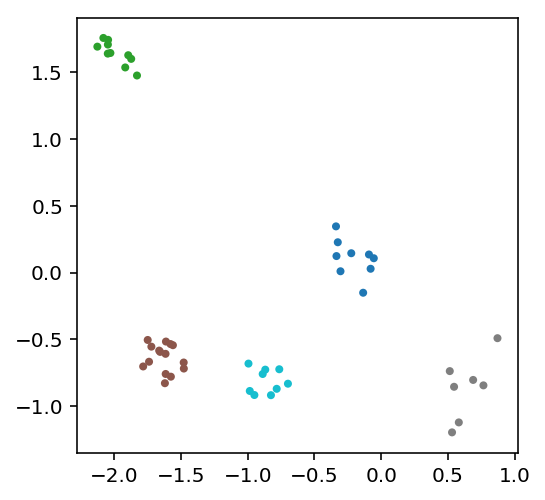

In [4]:
fig, ax = plt.subplots()
ax.scatter(*A.T, c=idx, cmap='tab10', marker='.')
ax.set_aspect(1)

In [5]:
def build_model(series, num_factors, num_communities, eps=1e-3, factors=None, update_order=None):
    """
    Build a model for latent factor analysis of time series with clustering of the observation model.
    """
    num_obs, num_nodes = series.shape
    factors = factors or {}
    default_factors = {
        'x': vb.MultiNormalDistribution(
            np.random.normal(0, eps, (num_obs, num_factors)),
            eps * np.ones((num_obs, 1, 1)) * np.eye(num_factors)
        ),
        'A': vb.MultiNormalDistribution(
            np.random.normal(0, eps, (num_nodes, num_factors)),
            np.ones((num_nodes, 1, 1)) * np.eye(num_factors)
        ),
        'tau': vb.GammaDistribution(
            eps * np.ones(num_nodes),
            eps * np.ones(num_nodes)
        )
    }
    
    default_update_order = ['x', 'A', 'tau']
    
    if num_communities is not None:        
        # Fit a k-means mixture model
        kmeans = sklearn.cluster.KMeans(num_communities)
        kmeans.fit(factors['A'].mean)
        z = np.zeros((num_nodes, num_communities))
        z[np.arange(num_nodes), kmeans.labels_] = 1
        
        default_factors.update({
            'z': vb.CategoricalDistribution(
                z
            ),
            'rho': vb.DirichletDistribution(
                np.ones(num_communities)
            ),
            'mu': vb.MultiNormalDistribution(
                kmeans.cluster_centers_,
                np.ones((num_communities, 1, 1)) * np.eye(num_factors) * 1e4
            ),
            'Lambda': vb.WishartDistribution(
                num_factors * np.ones(num_communities),
                np.ones((num_communities, 1, 1)) * np.eye(num_factors)

            )
        })
        
        default_update_order.extend(['Lambda', 'z', 'mu', 'rho'])
        
    default_factors.update(factors)
    factors = default_factors
    
    likelihoods = [
        # Distribution for collaborative filtering
        vb.CollaborativeFilteringDistribution(
            factors['x'], factors['A'], factors['tau'], strict=False
        ).likelihood(series),
        # Priors for regularisation
        vb.MultiNormalDistribution(
            np.zeros(num_factors), np.eye(num_factors)
        ).likelihood(factors['x']),
        vb.GammaDistribution(
            hyperparameters['tau/shape'], hyperparameters['tau/scale']
        ).likelihood(factors['tau']),
    ]
    
    if num_communities is not None:
        likelihoods.extend([
            # Mixture model
            vb.MixtureDistribution(
                factors['z'], vb.MultiNormalDistribution(
                    factors['mu'], 
                    factors['Lambda']
                )
            ).likelihood(
                vb.ReshapedDistribution(factors['A'], (num_nodes, 1))
            ),
            vb.CategoricalDistribution(
                factors['rho']
            ).likelihood(factors['z']),
            vb.MultiNormalDistribution(
                np.zeros(num_factors), 
                np.eye(num_factors) * hyperparameters['mu/precision']
            ).likelihood(factors['mu']),
            vb.WishartDistribution(
                num_factors + hyperparameters['Lambda/shape'],
                np.eye(num_factors) * num_factors * hyperparameters['Lambda/scale']
            ).likelihood(factors['Lambda']),
            vb.DirichletDistribution(
                hyperparameters['rho/concentration'] * np.ones(num_communities)
            ).likelihood(factors['rho'])
        ])
    else:
        likelihoods.extend([
            vb.MultiNormalDistribution(
                np.zeros(num_factors), np.eye(num_factors) * hyperparameters['A/precision']
            ).likelihood(factors['A']),
        ])
    
    return vb.Model(factors, likelihoods, update_order or default_update_order)

In [6]:
list_num_factors = np.asarray([1, 2, 3, 4])
elbos = []
best_elbo = -np.inf
best_model = None

# Iterate over the number of factors
for _num_factors in tqdm_notebook(list_num_factors):
    # Run a number of models in the ensemble
    model_args = (y, _num_factors, None)
    ensemble = vb.ModelEnsemble(build_model, model_args)
    ensemble.update(4, None, tqdm_notebook, convergence_predicate=1e-3, num_processes=4)
    elbos.append(ensemble.best_elbo)
    # Update the best ensemble
    if ensemble.best_elbo > best_elbo:
        best_elbo = ensemble.best_elbo
        best_model = ensemble.best_model
        
best_num_factors = list_num_factors[np.argmax(elbos)]
print(elbos)


[-6768.7165447731186, -3737.8842096371609, -4441.0731890566594, -5151.5818622110164]


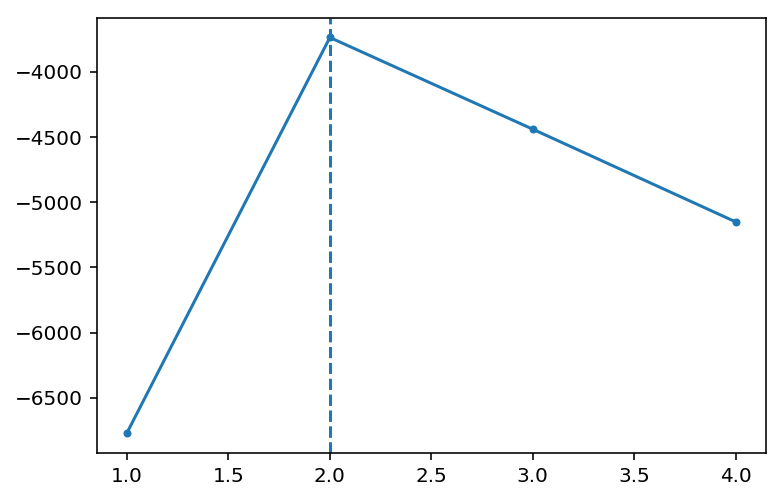

In [7]:
plt.plot(list_num_factors, elbos, marker='.')
plt.axvline(best_num_factors, ls=':')
plt.axvline(num_factors, ls='--')

<Container object of 3 artists>

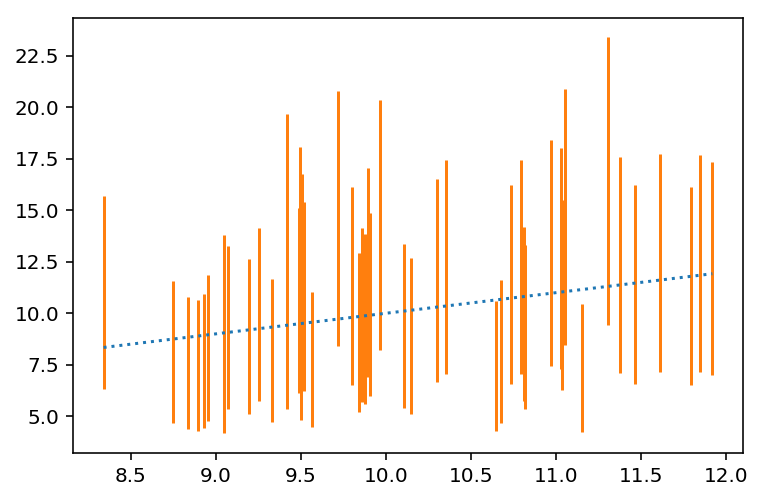

In [8]:
vb.plot_comparison(best_model['tau'], tau)

In [13]:
list_num_groups = np.asarray([2, 3, 4, 5, 6])
elbos2 = []
best_elbo2 = -np.inf
best_model2 = None
best_models = []

# Iterate over the number of factors
for _num_groups in tqdm_notebook(list_num_groups):
    # Run a number of models in the ensemble
    model_args = (y, best_num_factors, _num_groups)
    ensemble = vb.ModelEnsemble(build_model, model_args, {'factors': best_model.copy_factors()})
    ensemble.update(4, None, tqdm_notebook, convergence_predicate=1e-3, num_processes=4)
    elbos2.append(ensemble.best_elbo)
    best_models.append(ensemble.best_model)
    # Update the best ensemble
    if ensemble.best_elbo > best_elbo2:
        best_elbo2 = ensemble.best_elbo
        best_model2 = ensemble.best_model
        
best_num_groups = list_num_groups[np.argmax(elbos2)]
elbos2 = np.asarray(elbos2)
print(elbos2)


[-2658.04795825 -2651.64880723 -2666.62255635 -2681.76749302 -2706.09360764]


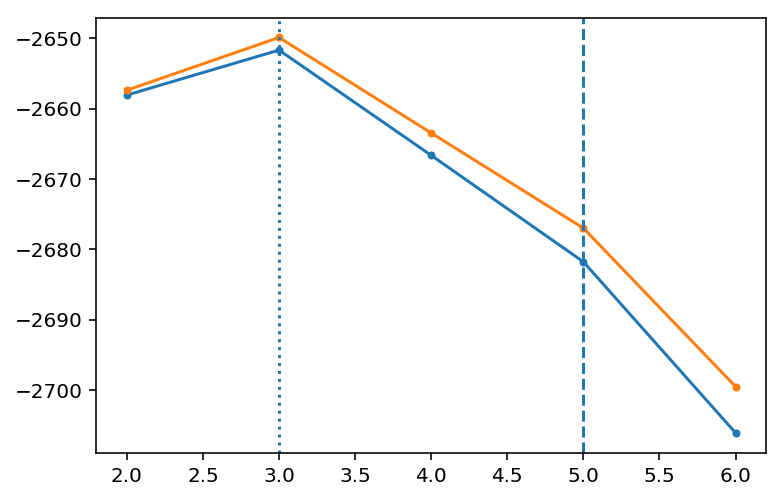

In [15]:
elbos2_corrected = elbos2 + scipy.special.gammaln(list_num_groups + 1)
plt.plot(list_num_groups, elbos2, marker='.')
plt.plot(list_num_groups, elbos2_corrected, marker='.')
plt.axvline(best_num_groups, ls=':')
plt.axvline(num_groups, ls='--')

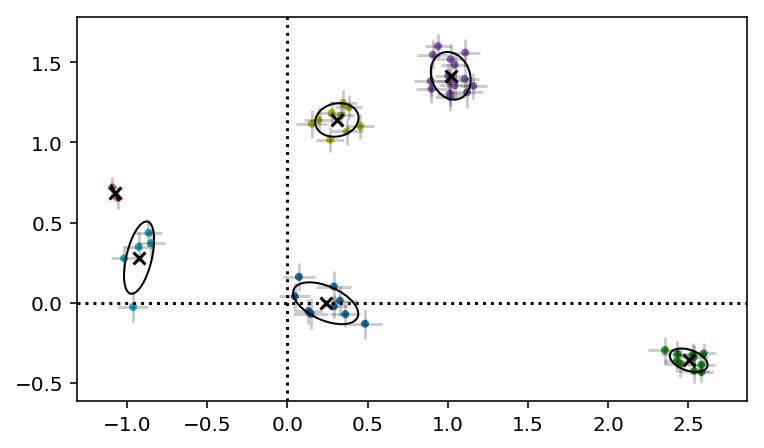

In [65]:
fig, ax = plt.subplots()
model = best_models[4]

best_idx = np.argmax(model['z'].mean, axis=1)
ax.scatter(*model['A'].mean.T, c=best_idx, cmap='tab10', marker='.')
ax.errorbar(*model['A'].mean.T, *reversed(3 * model['A'].std.T), ls='none', color='k', alpha=.2)

ax.scatter(*model['mu'].mean.T, marker='x', color='k')

#ax.scatter(*best_model['A'].mean.T, s=10, c=best_idx, cmap='tab10', marker='x')
#ax.errorbar(*best_model['A'].mean.T, *reversed(3 * best_model['A'].std.T), ls='none', color='k', alpha=.2)

for i in range(model['z'].mean.shape[1]):
    ellipse = vb.ellipse_from_cov(
        model['mu'].mean[i], 
        np.linalg.inv(model['Lambda'].mean[i]),
        facecolor='none', edgecolor='k'
    )
    ax.add_artist(ellipse)
    
ax.set_aspect(1)
ax.axhline(0, color='k', ls=':')
ax.axvline(0, color='k', ls=':')

In [59]:
best_model['x'].mean.std(axis=0) / best_model2['x'].mean.std(axis=0)

array([ 0.66311636,  0.68442669])

0.657812096055
0.675370368055


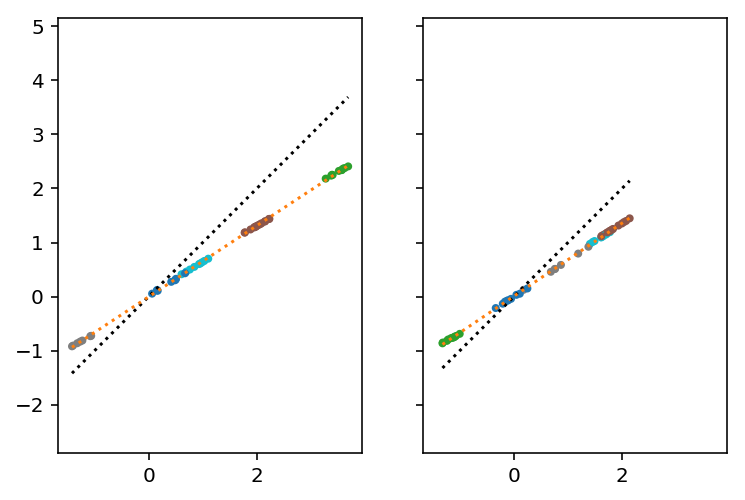

In [46]:
fig, axes = plt.subplots(1, 2, True, True)
kwargs = dict(c=idx, cmap='tab10', marker='.')
for i in [0, 1]:
    _x = best_model['A'].mean[:, i]
    _y = model['A'].mean[:, i]
    axes[i].scatter(_x, _y, **kwargs)
    linx = np.asarray([np.min(_x), np.max(_x)])
    axes[i].plot(linx, linx, color='k', ls=':')
    m, c = np.polyfit(_x, _y, 1)
    print(m)
    axes[i].plot(linx, c + m * linx, color='C1', ls=':')
    axes[i].set_aspect(1)

In [49]:
model.natural_parameters('A')

[{'mean': array([[ 1539.97983861,  1639.00890304],
         [ 1009.43899909,  1293.76616137],
         [ -725.27455824,   113.60372732],
         [ 1657.53550881,  1448.68124848],
         [  540.36235946,  1187.60806046],
         [ 1020.56581705,  1145.14410364],
         [  119.06252903,  -109.64465052],
         [ 2470.18302235,  -913.54566384],
         [  329.33477903,  1066.40558738],
         [ 1156.61692413,  1132.23503813],
         [   74.02766521,   -87.44514066],
         [ 3698.53940869, -1575.06275545],
         [  384.26562073,  -115.74772863],
         [  460.14741841,  1314.80533184],
         [  792.17719603,  1565.92963571],
         [  665.09780553,  1425.64271689],
         [-1084.20675761,   600.80962635],
         [ -680.81485714,   718.34965796],
         [  228.22378663,    56.03993706],
         [ 2596.40375304, -1031.32478915],
         [ 1075.13883589,   938.19518172],
         [ 1495.56188692,  -534.27575121],
         [  331.72367481,  -155.79904505],
   

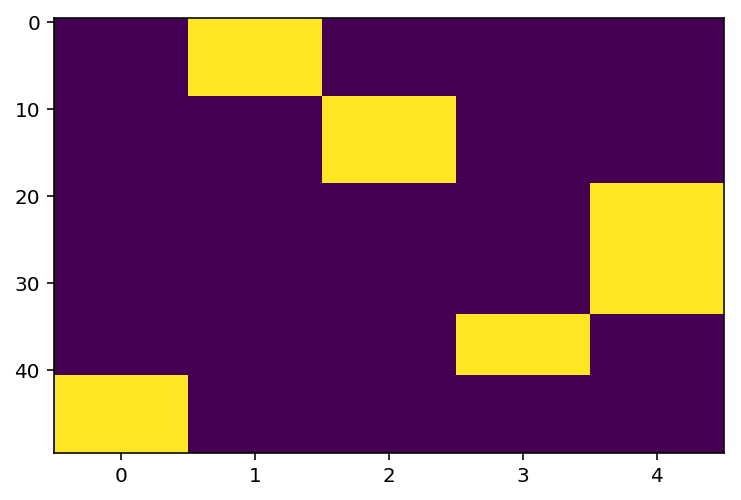

In [45]:
plt.imshow(model['z'].mean[np.argsort(idx)], aspect='auto')